You are hired by one of the leading news channels CNBE who wants to analyze recent elections. This survey was conducted on 1525 voters with 9 variables. You have to build a model, to predict which party a voter will vote for on the basis of the given information, to create an exit poll that will help in predicting overall win and seats covered by a particular party.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import roc_auc_score, roc_curve,classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split,GridSearchCV, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier,AdaBoostClassifier

In [2]:
from google.colab import drive
drive.mount("/content/drive",force_remount=True)

Mounted at /content/drive


#1.1) Read the dataset. Describe the data briefly. Interpret the inferences for each. Initial steps like head() .info(), Data Types, etc . Null value check, Summary stats, Skewness must be discussed.

In [3]:
path=("/content/drive/MyDrive/Election_Data.xlsx")
df=pd.read_excel(path,"Election_Dataset_Two Classes")

In [4]:
df.head()

,Unnamed: 0,vote,age,economic.cond.national,economic.cond.household,Blair,Hague,Europe,political.knowledge,gender
0,1,Labour,43,3,3,4,1,2,2,female
1,2,Labour,36,4,4,4,4,5,2,male
2,3,Labour,35,4,4,5,2,3,2,male
3,4,Labour,24,4,2,2,1,4,0,female
4,5,Labour,41,2,2,1,1,6,2,male


In [5]:
df.shape

(1525, 10)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1525 entries, 0 to 1524
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               1525 non-null   int64 
 1   vote                     1525 non-null   object
 2   age                      1525 non-null   int64 
 3   economic.cond.national   1525 non-null   int64 
 4   economic.cond.household  1525 non-null   int64 
 5   Blair                    1525 non-null   int64 
 6   Hague                    1525 non-null   int64 
 7   Europe                   1525 non-null   int64 
 8   political.knowledge      1525 non-null   int64 
 9   gender                   1525 non-null   object
dtypes: int64(8), object(2)
memory usage: 119.3+ KB


* There are 1525 entries in the data set and 9 Variables.
* There are 2 Object data types in the data set which are Vote and Gender, 8 integer data type. Unnamed column can be dropped from the data set as it has no use.
* Age is the only variable in the dataset which is continuous and all the other variables such as economic.cond.national, economic.cond.household, Blair, Hague, Europe, Political Knowledge are all ordinal values we should convert them into Object data type before further proceedings

In [7]:
df.duplicated().sum()

0

In [ ]:
df.isnull().sum()

Unnamed: 0                 0
vote                       0
age                        0
economic.cond.national     0
economic.cond.household    0
Blair                      0
Hague                      0
Europe                     0
political.knowledge        0
gender                     0
dtype: int64

There are no null values in the data set.



In [ ]:
df.drop(["Unnamed: 0"],axis=1,inplace=True)

In [ ]:
df["economic.cond.national"]=df["economic.cond.national"].astype("object")
df["economic.cond.household"]=df["economic.cond.household"].astype("object")
df["Blair"]=df["Blair"].astype("object")
df["Hague"]=df["Hague"].astype("object")
df["Europe"]=df["Europe"].astype("object")
df["political.knowledge"]=df["political.knowledge"].astype("object")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1525 entries, 0 to 1524
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   vote                     1525 non-null   object
 1   age                      1525 non-null   int64 
 2   economic.cond.national   1525 non-null   object
 3   economic.cond.household  1525 non-null   object
 4   Blair                    1525 non-null   object
 5   Hague                    1525 non-null   object
 6   Europe                   1525 non-null   object
 7   political.knowledge      1525 non-null   object
 8   gender                   1525 non-null   object
dtypes: int64(1), object(8)
memory usage: 107.4+ KB


* The variables: economic.cond.national,economic.cond.household, Blair, Hague, Europe and Political Knowledge are in object data type.
* There is 1 integer data type and 8 object data type variables in the data set.



In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1525.0,54.182295,15.711209,24.0,41.0,53.0,67.0,93.0


* Age variable in the data set is slightly right skewed.


In [ ]:
cat=[]
for i in df.columns:
  if df[i].dtype=="object":
    cat.append(i)
print(cat)

['vote', 'economic.cond.national', 'economic.cond.household', 'Blair', 'Hague', 'Europe', 'political.knowledge', 'gender']


In [ ]:
df[cat].describe().T

,count,unique,top,freq
vote,1525,2,Labour,1063
economic.cond.national,1525,5,3,607
economic.cond.household,1525,5,3,648
Blair,1525,5,4,836
Hague,1525,5,2,624
Europe,1525,11,11,338
political.knowledge,1525,4,2,782
gender,1525,2,female,812


* From a scale of 1 to 5, majority of voters has given an Assessment for national economic condition and household economic condition as 3.
* As for the Assessment for the Leader of Labour party leader – Blair, majority of the voters has rated him 4 from a scale of 1 to 5, which is more than the average.
* Whereas, the Leader of Conservative party – Hague, is given a rating of 2 from a scale of 1 to 5, which is below average.
* For assessment made on respondent’s attitude towards European integration,
majority of the voters has given a high score of 11, from a scale of 1 to 11.
* From this we can say that Eurosceptic sentiment is high among the voters.
Majority of the voters know the position of Political party’s stand on European
integration.


#1.2) Perform EDA (Check the null values, Data types, shape, Univariate, bivariate analysis). Also check for outliers (4 pts). Interpret the inferences for each (3 pts) Distribution plots(histogram) or similar plots for the continuous columns. Box plots. Appropriate plots for categorical variables. Inferences on each plot. Outliers proportion should be discussed, and inferences from above used plots should be there. There is no restriction on how the learner wishes to implement this but the code should be able to represent the correct output and inferences should be logical and correct.

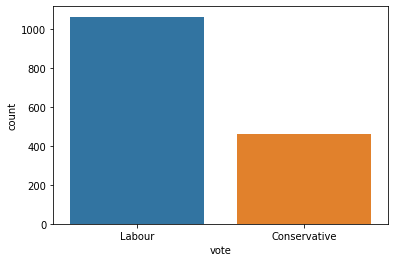

In [ ]:
sns.countplot(data=df,x="vote");

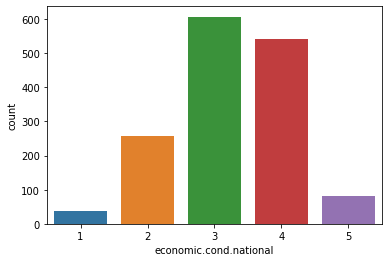

In [ ]:
sns.countplot(data=df,x="economic.cond.national");

In [ ]:
df["economic.cond.national"].value_counts()

3    607
4    542
2    257
5     82
1     37
Name: economic.cond.national, dtype: int64

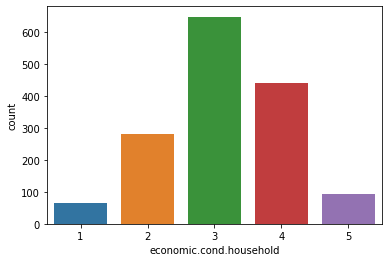

In [ ]:
sns.countplot(data=df,x="economic.cond.household");

In [ ]:
df["economic.cond.household"].value_counts()

3    648
4    440
2    280
5     92
1     65
Name: economic.cond.household, dtype: int64

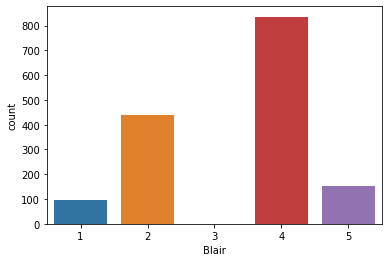

In [ ]:
sns.countplot(data=df,x="Blair");

In [ ]:
df["Blair"].value_counts()

4    836
2    438
5    153
1     97
3      1
Name: Blair, dtype: int64

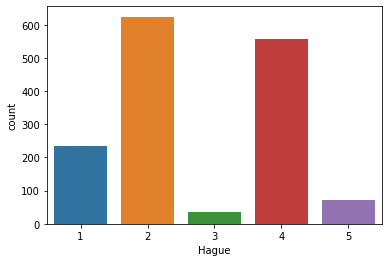

In [ ]:
sns.countplot(data=df,x="Hague");

In [ ]:
df["Hague"].value_counts()

2    624
4    558
1    233
5     73
3     37
Name: Hague, dtype: int64

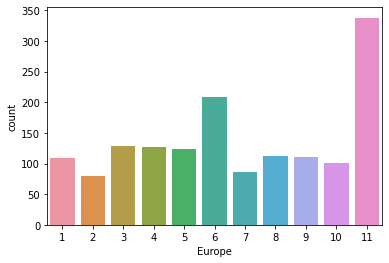

In [ ]:
sns.countplot(data=df,x="Europe");

In [ ]:
df["Europe"].value_counts()

11    338
6     209
3     129
4     127
5     124
8     112
9     111
1     109
10    101
7      86
2      79
Name: Europe, dtype: int64

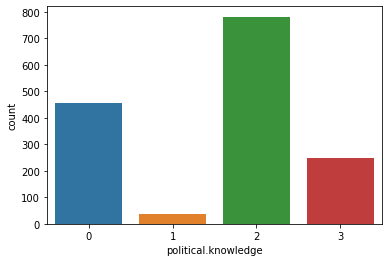

In [ ]:
sns.countplot(data=df,x="political.knowledge");

In [ ]:
df["political.knowledge"].value_counts()

2    782
0    455
3    250
1     38
Name: political.knowledge, dtype: int64

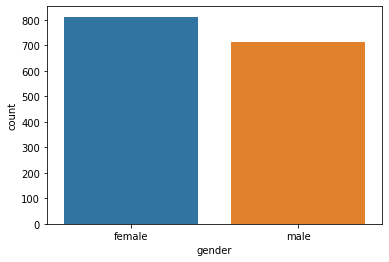

In [ ]:
sns.countplot(data=df,x="gender");

In [ ]:
df["gender"].value_counts()

female    812
male      713
Name: gender, dtype: int64

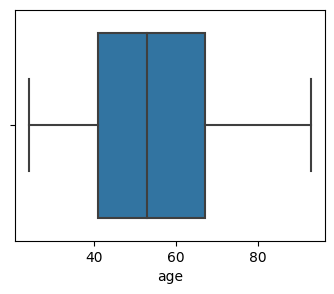

In [ ]:
plt.figure(figsize=(4,3))
sns.boxplot(data=df,x="age");

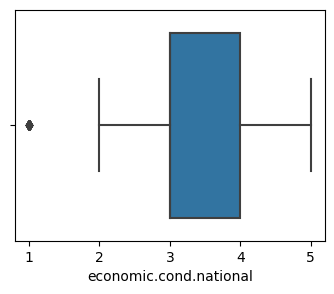

In [ ]:
plt.figure(figsize=(4,3))
sns.boxplot(data=df,x="economic.cond.national");

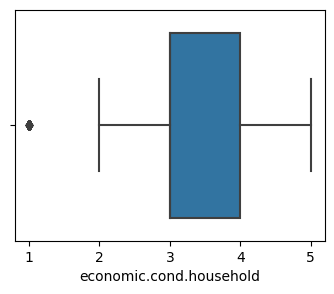

In [ ]:
plt.figure(figsize=(4,3))
sns.boxplot(data=df,x="economic.cond.household");

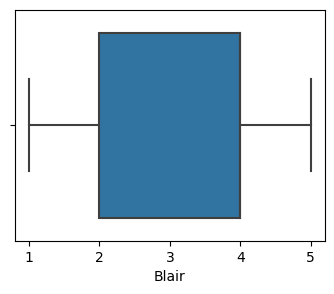

In [ ]:
plt.figure(figsize=(4,3))
sns.boxplot(data=df,x="Blair");

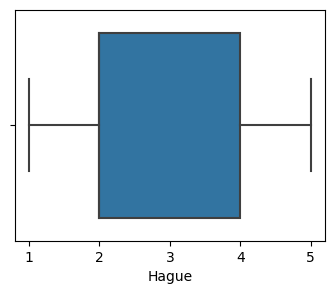

In [ ]:
plt.figure(figsize=(4,3))
sns.boxplot(data=df,x="Hague");

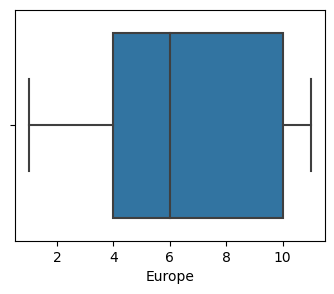

In [ ]:
plt.figure(figsize=(4,3))
sns.boxplot(data=df,x="Europe");

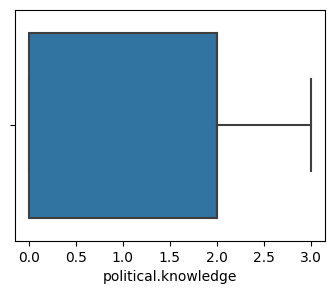

In [ ]:
plt.figure(figsize=(4,3))
sns.boxplot(data=df,x="political.knowledge");

#Insights from univariate analysis:
* The voters have picked Labour party over Conservative party.
* On a scale from 1 to 5, the economic condition of nation is rated as 3 by 607 voters, with 4 by 542 voters, 2 by 257 voters, 5 by 82 voters and 1 by 37 voter which is the least.
* The economic condition of household on a scale of 1 to 5, maximum number of households has a scale of 3 with 648 households, 4 with 440 households.
* Assessment of Labour party Leader Blair, on a scale
from 1 to 5, maximum number of voters rated him 4 by 836 voters which is above
average followed by a rating of 2 by 438 voters.
* Assessment of Conservative party Leader Hague, on a scale from 1 to 5, maximum number of voters rated him 2 by 624 voters which is below average followed by a rating of 4 by 558 voters.Least number of voters rated him as 3 by 37 voters.
* Assessment of respondents attitude towards European Integration on a scale from 1 to 11, maximum number of voters have given an assessment of 11 which shows high Eurosceptic Sentiment in the voters, which is followed by 6 as assessment which shows average sentiment.
* Count of Political Knowledge i.e., party’s positions on European Integration on a scale from 0 to 3, maximum numbers of voters given 2 as an answer followed by 0
* The number of females – 832 in the survey is more than the male voters – 713
* The votes for Labour party are high for national economic conditions 3, 4 and 5. Whereas the votes for Conservative party are high for national economic conditions 1 and 2
* The votes for Labour party are high for all household economic conditions

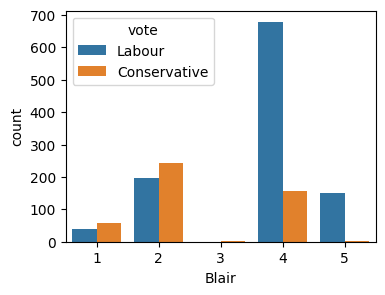

In [ ]:
plt.figure(figsize=(4,3))
sns.countplot(data=df,x="Blair",hue="vote");

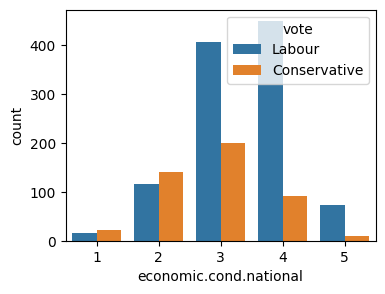

In [ ]:
plt.figure(figsize=(4,3))
sns.countplot(data=df,x="economic.cond.national",hue="vote");

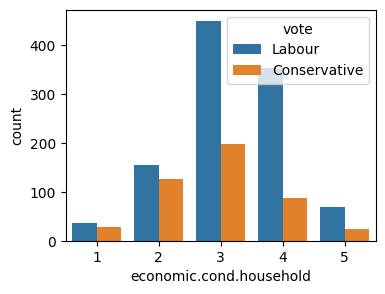

In [ ]:
plt.figure(figsize=(4,3))
sns.countplot(data=df,x="economic.cond.household",hue="vote");

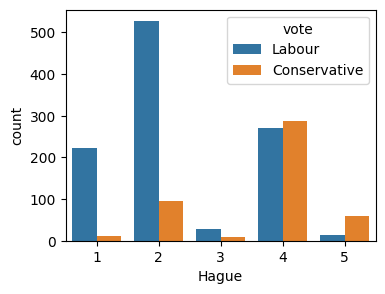

In [ ]:
plt.figure(figsize=(4,3))
sns.countplot(data=df,x="Hague",hue="vote");

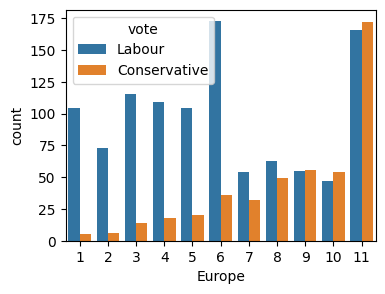

In [ ]:
plt.figure(figsize=(4,3))
sns.countplot(data=df,x="Europe",hue="vote");

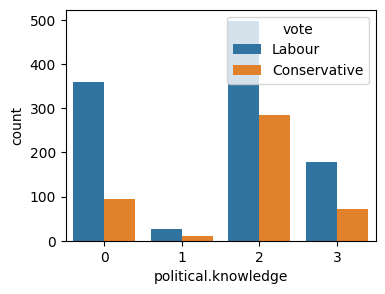

In [ ]:
plt.figure(figsize=(4,3))
sns.countplot(data=df,x="political.knowledge",hue="vote");

<Axes: xlabel='gender', ylabel='count'>

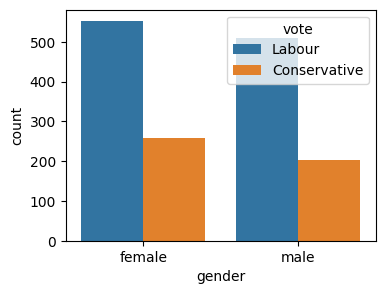

In [ ]:
plt.figure(figsize=(4,3))
sns.countplot(data=df,x="gender",hue="vote")

#Insights from Bivariate analysis:
* Voters who have given Blair rating of 4 and 5 have more votes for Labour party and who have given 1 and 2 have more votes for conservative party.
* Voters who have given Hague rating of 4 and 5 have more votes for Conservative party and who have given 1, 2 and 3 have more votes for Labour party.
* Voters who have positive attitude towards European integration have voted for Conservative party compared to Labour party,Voters who are less positive towards European integration have voted more for Labour party.
* Voters have voted for Labour party more than the conservative party irrespective of their knowledge on party’s position towards European integration


#1.3) Encode the data (having string values) for Modelling. Is Scaling necessary here or not?( 2 pts), Data Split: Split the data into train and test (70:30) (2 pts). The learner is expected to check and comment about the difference in scale of different features on the bases of appropriate measure for example std dev, variance, etc. Should justify whether there is a necessity for scaling. Object data should be converted into categorical/numerical data to fit in the models. (pd.categorical().codes(), pd.get_dummies(drop_first=True)) Data split, ratio defined for the split, train-test split should be discussed.

In [ ]:
df["vote"].value_counts()

Labour          1063
Conservative     462
Name: vote, dtype: int64

In [ ]:
df["vote"]=df["vote"].astype("category")

In [ ]:
df["vote"]=df["vote"].cat.codes

In [ ]:
df_new=pd.get_dummies(data=df,columns=["gender"],drop_first=True)

In [ ]:
df_new.head()

,vote,age,economic.cond.national,economic.cond.household,Blair,Hague,Europe,political.knowledge,gender_male
0,1,43,3,3,4,1,2,2,0
1,1,36,4,4,4,4,5,2,1
2,1,35,4,4,5,2,3,2,1
3,1,24,4,2,2,1,4,0,0
4,1,41,2,2,1,1,6,2,1


* Vote variable data type is converted into Category.
* After the conversion categorical codes were generated and code for Labour party is 1 and Conservative party is 0.
* By using get_dummies and using drop_first data, data encoding is done for gender variable.

* Scaling is not necessary for all models, only K Nearest Neighbours model needs scaling as it is distance based algorithm, all the variables need to be in the same scale.
* Scaling of variables like national economic condition, household economic condition, Blair, Hague are all same, as they are all assessed with a scale from 1 to 5.
* Vote and Gender variable are also in same scale, in binary – 0 and 1
Age, Europe and Political knowledge columns are all in different scales.
* To build the Machine learning models, we need to split the data set into training and test data
* There are 0 and 1 values in the dependent variable and the number of 1’s in
dependent variable is way more than the number of values.
* We need to ensure there is a balance in the split of 0 and 1’s in train and test split.
* To ensure this stratify function is used when splitting the data into train and test.
* Training and testing set are divided in the ratio of 70:30, 70% of the data goes to training set and 30% goes to test set and the random_state is set as 1.

In [ ]:
df_new.describe().T

,count,mean,std,min,25%,50%,75%,max
vote,1525.0,0.697049,0.459685,0.0,0.0,1.0,1.0,1.0
age,1525.0,54.182295,15.711209,24.0,41.0,53.0,67.0,93.0
gender_male,1525.0,0.467541,0.499109,0.0,0.0,0.0,1.0,1.0


In [ ]:
X=df_new.drop(["vote"],axis=1)
y=df_new["vote"]

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=1,stratify=y)

In [ ]:
y.value_counts()

1    1063
0     462
Name: vote, dtype: int64

#1.4) Apply Logistic Regression and LDA (Linear Discriminant Analysis) (2 pts). Interpret the inferences of both model s (2 pts). Successful implementation of each model. Logical reason should be shared if any custom changes are made to the parameters while building the model. Calculate Train and Test Accuracies for each model. Comment on the validness of models (over fitting or under fitting)

#Logistic Regression
Logistic Regression model is built on training and test data set with hyper
parameters set as default.

In [ ]:
LG=LogisticRegression()
model_lg=LG.fit(X_train,y_train)

In [ ]:
ytrain_predictlg=model_lg.predict(X_train)
ytest_predictlg=model_lg.predict(X_test)

In [ ]:
print(metrics.confusion_matrix(y_train,ytrain_predictlg))
print(metrics.classification_report(y_train,ytrain_predictlg))

[[210 113]
 [ 69 675]]
              precision    recall  f1-score   support

           0       0.75      0.65      0.70       323
           1       0.86      0.91      0.88       744

    accuracy                           0.83      1067
   macro avg       0.80      0.78      0.79      1067
weighted avg       0.83      0.83      0.83      1067



In [ ]:
tn,fp,fn,tp=confusion_matrix(y_train,ytrain_predictlg).ravel()
tn,fp,fn,tp

(210, 113, 69, 675)

In [ ]:
print(metrics.confusion_matrix(y_test,ytest_predictlg))
print(metrics.classification_report(y_test,ytest_predictlg))

[[ 94  45]
 [ 24 295]]
              precision    recall  f1-score   support

           0       0.80      0.68      0.73       139
           1       0.87      0.92      0.90       319

    accuracy                           0.85       458
   macro avg       0.83      0.80      0.81       458
weighted avg       0.85      0.85      0.85       458



In [ ]:
tn,fp,fn,tp=confusion_matrix(y_test,ytest_predictlg).ravel()
tn,fp,fn,tp

(94, 45, 24, 295)

In [ ]:
y_trainprobslg=model_lg.predict_proba(X_train)
y_testprobslg=model_lg.predict_proba(X_test)

In [ ]:
y_trainprobslg=y_trainprobslg[:,1]

In [ ]:
y_testprobslg=y_testprobslg[:,1]

0.8768205499517294


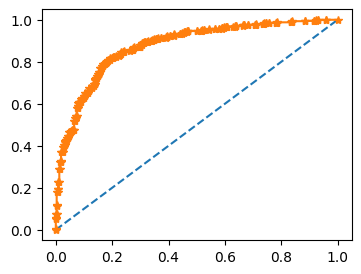

In [ ]:
auc_trainlg=roc_auc_score(y_train,y_trainprobslg)
print(auc_trainlg)
fpr,tpr,thresholds=roc_curve(y_train,y_trainprobslg)
plt.figure(figsize=(4,3))
plt.plot([0,1],[0,1],linestyle="--")
plt.plot(fpr,tpr,marker="*")
plt.show()

0.914232877021267


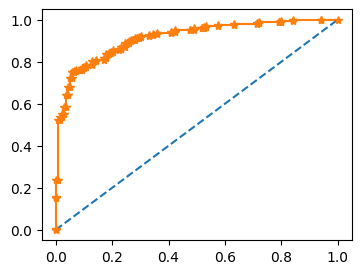

In [ ]:
auc_testlg=roc_auc_score(y_test,y_testprobslg)
print(auc_testlg)
fpr,tpr,thresholds=roc_curve(y_test,y_testprobslg)
plt.figure(figsize=(4,3))
plt.plot([0,1],[0,1],linestyle="--")
plt.plot(fpr,tpr,marker="*")
plt.show()

#Inference:
From accuracy, Precision and recall values, the model seems to be performing well on both the train and test data.

#Linear Discriminant Analysis
Linear Discriminant analysis model is built on train and test with default hyper parameters.

In [ ]:
lda=LinearDiscriminantAnalysis()
model_lda=lda.fit(X_train,y_train)

In [ ]:
ytrain_predictlda=model_lda.predict(X_train)
ytest_predictlda=model_lda.predict(X_test)

In [ ]:
print(metrics.confusion_matrix(y_train,ytrain_predictlda))
print(metrics.classification_report(y_train,ytrain_predictlda))

[[215 108]
 [ 78 666]]
              precision    recall  f1-score   support

           0       0.73      0.67      0.70       323
           1       0.86      0.90      0.88       744

    accuracy                           0.83      1067
   macro avg       0.80      0.78      0.79      1067
weighted avg       0.82      0.83      0.82      1067



In [ ]:
print(metrics.confusion_matrix(y_test,ytest_predictlda))
print(metrics.classification_report(y_test,ytest_predictlda))

[[ 97  42]
 [ 29 290]]
              precision    recall  f1-score   support

           0       0.77      0.70      0.73       139
           1       0.87      0.91      0.89       319

    accuracy                           0.84       458
   macro avg       0.82      0.80      0.81       458
weighted avg       0.84      0.84      0.84       458



In [ ]:
y_trainprobslda=model_lda.predict_proba(X_train)
y_testprobslda=model_lda.predict_proba(X_test)

In [ ]:
y_trainprobslda=y_trainprobslda[:,1]

In [ ]:
y_testprobslda=y_testprobslda[:,1]

0.8764169080195745


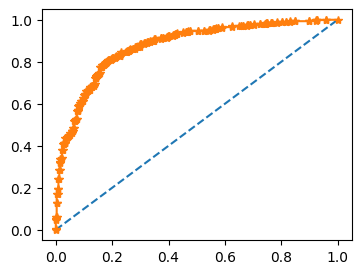

In [ ]:
auc_trainlda=roc_auc_score(y_train,y_trainprobslda)
print(auc_trainlda)
fpr,tpr,thresholds=roc_curve(y_train,y_trainprobslda)
plt.figure(figsize=(4,3))
plt.plot([0,1],[0,1],linestyle="--")
plt.plot(fpr,tpr,marker="*")
plt.show()

0.9149320042398682


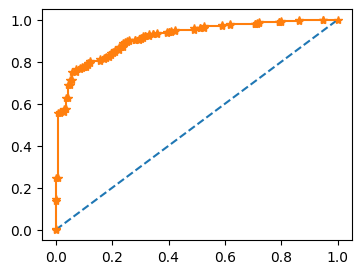

In [ ]:
auc_testlda=roc_auc_score(y_test,y_testprobslda)
print(auc_testlda)
fpr,tpr,thresholds=roc_curve(y_test,y_testprobslda)
plt.figure(figsize=(4,3))
plt.plot([0,1],[0,1],linestyle="--")
plt.plot(fpr,tpr,marker="*")
plt.show()

From accuracy, precision and recall, we see that LDA model is performing well in
train and testing data.

# Inferences:
* From the above model Logistic Regression and LDA we can see that the accuracy
for training set of both the models is same but the test data accuracies are different with 85% accuracy for test set in Logistic Regression and 84% in LDA.
* Logistic Regression model is good at classifying true positives and false positives when compared to LDA.
* Whereas LDA model is good at classifying True Negatives and False Negatives in comparison with Logistic Regression.
* There is not much differences in all the performance metrics in training and test sets of each individual models, so the model are a good fit.
* Auc scores for training and test for Logistic Regression model are 87% and 91%.
* For LDA model, AUC scores are as follows for train and test set: 87% and 91%

#1.5) Apply KNN Model and Naïve Bayes Model (2pts). Interpret the inferences of each model (2 pts). Successful implementation of each model. Logical reason should be shared if any custom changes are made to the parameters while building the model. Calculate Train and Test Accuracies for each model. Comment on the validness of models (over fitting or under fitting)

* From sklearn.preprocessing imported StandardScalar for scaling X_train and X_test and transformed into the same scale, as K nearest neighbors classifier is distance based.
* After scaling scaled X_train and X_test are fit into KNN model.

#K Nearest Neighbor

In [ ]:
SS=StandardScaler()
X_trainscaled=SS.fit_transform(X_train)
X_testscaled=SS.transform(X_test)

In [ ]:
knn=KNeighborsClassifier()
model_knn=knn.fit(X_trainscaled,y_train)

In [ ]:
ytrain_predictknn=model_knn.predict(X_trainscaled)
ytest_predictknn=model_knn.predict(X_testscaled)

In [ ]:
print(metrics.confusion_matrix(y_train,ytrain_predictknn))
print(metrics.classification_report(y_train,ytrain_predictknn))

[[239  84]
 [ 70 674]]
              precision    recall  f1-score   support

           0       0.77      0.74      0.76       323
           1       0.89      0.91      0.90       744

    accuracy                           0.86      1067
   macro avg       0.83      0.82      0.83      1067
weighted avg       0.85      0.86      0.85      1067



In [ ]:
tn,fp,fn,tp=confusion_matrix(y_train,ytrain_predictknn).ravel()
tn,fp,fn,tp

(239, 84, 70, 674)

In [ ]:
print(metrics.confusion_matrix(y_test,ytest_predictknn))
print(metrics.classification_report(y_test,ytest_predictknn))

[[ 97  42]
 [ 35 284]]
              precision    recall  f1-score   support

           0       0.73      0.70      0.72       139
           1       0.87      0.89      0.88       319

    accuracy                           0.83       458
   macro avg       0.80      0.79      0.80       458
weighted avg       0.83      0.83      0.83       458



In [ ]:
y_trainprobsknn=model_knn.predict_proba(X_train)
y_testprobsknn=model_knn.predict_proba(X_test)

In [ ]:
y_trainprobsknn=y_trainprobsknn[:,1]

In [ ]:
y_testprobsknn=y_testprobsknn[:,1]

0.7975694097673025


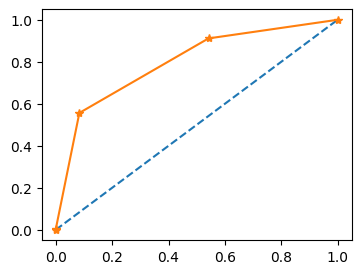

In [ ]:
auc_trainknn=roc_auc_score(y_train,y_trainprobsknn)
print(auc_trainknn)
fpr,tpr,thresholds=roc_curve(y_train,y_trainprobsknn)
plt.figure(figsize=(4,3))
plt.plot([0,1],[0,1],linestyle="--")
plt.plot(fpr,tpr,marker="*")
plt.show()

0.8317922464536207


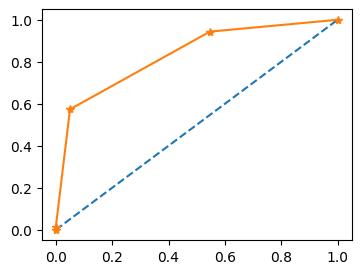

In [ ]:
auc_testknn=roc_auc_score(y_test,y_testprobsknn)
print(auc_testknn)
fpr,tpr,thresholds=roc_curve(y_test,y_testprobsknn)
plt.figure(figsize=(4,3))
plt.plot([0,1],[0,1],linestyle="--")
plt.plot(fpr,tpr,marker="*")
plt.show()

#Gaussian Naive Bayes Classifier
Gaussian naïve Bayes model is built by using default hyper parameters on training
and test sets

In [ ]:
NB=GaussianNB()
model_nb=NB.fit(X_train,y_train)

In [ ]:
ytrain_predictnb=model_nb.predict(X_train)
ytest_predictnb=model_nb.predict(X_test)

In [ ]:
print(metrics.confusion_matrix(y_train,ytrain_predictnb))
print(metrics.classification_report(y_train,ytrain_predictnb))

[[223 100]
 [ 90 654]]
              precision    recall  f1-score   support

           0       0.71      0.69      0.70       323
           1       0.87      0.88      0.87       744

    accuracy                           0.82      1067
   macro avg       0.79      0.78      0.79      1067
weighted avg       0.82      0.82      0.82      1067



In [ ]:
print(metrics.confusion_matrix(y_test,ytest_predictnb))
print(metrics.classification_report(y_test,ytest_predictnb))

[[101  38]
 [ 32 287]]
              precision    recall  f1-score   support

           0       0.76      0.73      0.74       139
           1       0.88      0.90      0.89       319

    accuracy                           0.85       458
   macro avg       0.82      0.81      0.82       458
weighted avg       0.85      0.85      0.85       458



In [ ]:
y_trainprobsnb=model_nb.predict_proba(X_train)
y_testprobsnb=model_nb.predict_proba(X_test)

In [ ]:
y_trainprobsnb=y_trainprobsnb[:,1]

In [ ]:
y_testprobsnb=y_testprobsnb[:,1]

0.874357085788475


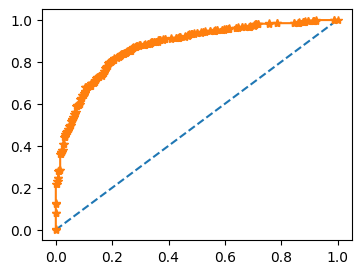

In [ ]:
auc_trainnb=roc_auc_score(y_train,y_trainprobsnb)
print(auc_trainnb)
fpr,tpr,thresholds=roc_curve(y_train,y_trainprobsnb)
plt.figure(figsize=(4,3))
plt.plot([0,1],[0,1],linestyle="--")
plt.plot(fpr,tpr,marker="*")
plt.show()

0.909993008727814


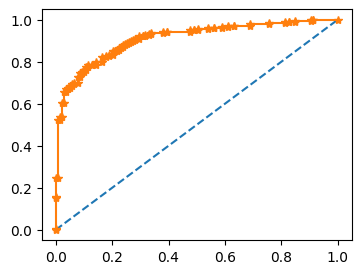

In [ ]:
auc_testnb=roc_auc_score(y_test,y_testprobsnb)
print(auc_testnb)
fpr,tpr,thresholds=roc_curve(y_test,y_testprobsnb)
plt.figure(figsize=(4,3))
plt.plot([0,1],[0,1],linestyle="--")
plt.plot(fpr,tpr,marker="*")
plt.show()

#Inferences on both models: KNN and Gaussian NB:
* KNN model is good at classifying True positives and true negatives on training set in comparison with Gaussian NB.
* Gaussian NB is good in classifying True positives and True Negatives on test set in comparison with KNN.
* AUC scores of KNN for train and Test are 79% and 83%.
* AUC scores of Gaussian for train and test are 87% and 90%.
* The accuracy of KNN model is good in training set.
* The accuracy of Gaussian model is good in test set.
* In accounts of Accuracy, Precision and Recall K Nearest Neighbors model didn’t perform well in test set as it performed in training set.
* Whereas for Gaussian NB model it performed well in test set than in train set

#1.6) Model Tuning (4 pts) , Bagging ( 1.5 pts) and Boosting (1.5 pts). Apply grid search on each model (include all models) and make models on best_params. Compare and comment on performances of all. Comment on feature importance if applicable. Successful implementation of both algorithms along with inferences and comments on the model performances.

#MODEL TUNING

# Grid Search - Logistic Regression
Logistic Regression model built using hyper parameters Grid Search:
For optimizing Logistic Regression model, the best parameters are found using Grid SearchCV.


In [ ]:
solvers=["newton-cg","lbfgs","liblinear","saga"]
penalty=["l1","l2"]
c_values=[100,10,1.0,0.1,0.01]
grid=dict(solver=solvers,penalty=penalty,C=c_values)

In [ ]:
gs=GridSearchCV(estimator=LG,param_grid=grid,n_jobs=-1)

In [ ]:
gs.fit(X_train,y_train)

GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01],
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga']})

In [ ]:
gs.cv_results_["params"]

[{'C': 100, 'penalty': 'l1', 'solver': 'newton-cg'},
 {'C': 100, 'penalty': 'l1', 'solver': 'lbfgs'},
 {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'},
 {'C': 100, 'penalty': 'l1', 'solver': 'saga'},
 {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'},
 {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'},
 {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'},
 {'C': 100, 'penalty': 'l2', 'solver': 'saga'},
 {'C': 10, 'penalty': 'l1', 'solver': 'newton-cg'},
 {'C': 10, 'penalty': 'l1', 'solver': 'lbfgs'},
 {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'},
 {'C': 10, 'penalty': 'l1', 'solver': 'saga'},
 {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'},
 {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'},
 {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'},
 {'C': 10, 'penalty': 'l2', 'solver': 'saga'},
 {'C': 1.0, 'penalty': 'l1', 'solver': 'newton-cg'},
 {'C': 1.0, 'penalty': 'l1', 'solver': 'lbfgs'},
 {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'},
 {'C': 1.0, 'penalty': 'l1', 'solver': 's

In [ ]:
gs.best_params_

{'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}

In [ ]:
lg=LogisticRegression(C=0.01,penalty="l2",solver="newton-cg")
model_LG=lg.fit(X_train,y_train)
ytrain_predictLG=model_LG.predict(X_train)
ytest_predictLG=model_LG.predict(X_test)
print(metrics.confusion_matrix(y_train,ytrain_predictLG))
print(metrics.classification_report(y_train,ytrain_predictLG))

[[195 128]
 [ 57 687]]
              precision    recall  f1-score   support

           0       0.77      0.60      0.68       323
           1       0.84      0.92      0.88       744

    accuracy                           0.83      1067
   macro avg       0.81      0.76      0.78      1067
weighted avg       0.82      0.83      0.82      1067



In [ ]:
print(metrics.confusion_matrix(y_test,ytest_predictLG))
print(metrics.classification_report(y_test,ytest_predictLG))

[[ 91  48]
 [ 23 296]]
              precision    recall  f1-score   support

           0       0.80      0.65      0.72       139
           1       0.86      0.93      0.89       319

    accuracy                           0.84       458
   macro avg       0.83      0.79      0.81       458
weighted avg       0.84      0.84      0.84       458



In [ ]:
y_trainprobsLG=model_LG.predict_proba(X_train)
y_testprobsLG=model_LG.predict_proba(X_test)

In [ ]:
y_trainprobsLG=y_trainprobsLG[:,1]

In [ ]:
y_testprobsLG=y_testprobsLG[:,1]

0.8738202836312794


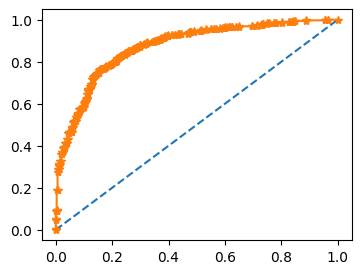

In [ ]:
auc_trainLG=roc_auc_score(y_train,y_trainprobsLG)
print(auc_trainLG)
fpr,tpr,thresholds=roc_curve(y_train,y_trainprobsLG)
plt.figure(figsize=(4,3))
plt.plot([0,1],[0,1],linestyle="--")
plt.plot(fpr,tpr,marker="*")
plt.show()

0.9112559482194807


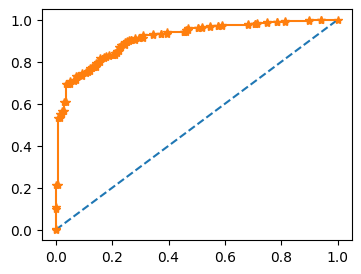

In [ ]:
auc_testLG=roc_auc_score(y_test,y_testprobsLG)
print(auc_testLG)
fpr,tpr,thresholds=roc_curve(y_test,y_testprobsLG)
plt.figure(figsize=(4,3))
plt.plot([0,1],[0,1],linestyle="--")
plt.plot(fpr,tpr,marker="*")
plt.show()

* For training set, accuracy seems to be the same before using Grid Search.
* However, True positives classification seems to be increased and True negatives are decreased for the training set.
* % of Precision, recall and f1 score is increased.
* For test set, True negatives have increased, accuracy of the model also increased.
* AUC scores for both training and test set remained same.


# Grid Search - Linear Discriminant Analysis
For optimizing the performance of the LDA model, best hyper parameters are found
by using Grid Search.


In [ ]:
model=LinearDiscriminantAnalysis()
solver=["svd","lsqr","eigen"]
shrikage=["auto",0.1,0.5]
cv=RepeatedStratifiedKFold(n_splits=10,n_repeats=3,random_state=1)
grid=dict(solver=solver,shrinkage=shrikage)

In [ ]:
gs1=GridSearchCV(estimator=model,param_grid=grid,n_jobs=-1,cv=cv)

In [ ]:
gs1.fit(X_train,y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1),
             estimator=LinearDiscriminantAnalysis(), n_jobs=-1,
             param_grid={'shrinkage': ['auto', 0.1, 0.5],
                         'solver': ['svd', 'lsqr', 'eigen']})

In [ ]:
gs1.cv_results_["params"]

[{'shrinkage': 'auto', 'solver': 'svd'},
 {'shrinkage': 'auto', 'solver': 'lsqr'},
 {'shrinkage': 'auto', 'solver': 'eigen'},
 {'shrinkage': 0.1, 'solver': 'svd'},
 {'shrinkage': 0.1, 'solver': 'lsqr'},
 {'shrinkage': 0.1, 'solver': 'eigen'},
 {'shrinkage': 0.5, 'solver': 'svd'},
 {'shrinkage': 0.5, 'solver': 'lsqr'},
 {'shrinkage': 0.5, 'solver': 'eigen'}]

In [ ]:
gs1.best_params_

{'shrinkage': 'auto', 'solver': 'lsqr'}

In [ ]:
LDA=LinearDiscriminantAnalysis(solver="lsqr",shrinkage="auto")
model_LDA=LDA.fit(X_train,y_train)
ytrain_predictLDA=model_LDA.predict(X_train)
ytest_predictLDA=model_LDA.predict(X_test)
print(metrics.confusion_matrix(y_train,ytrain_predictLDA))
print(metrics.classification_report(y_train,ytrain_predictLDA))

[[218 105]
 [ 78 666]]
              precision    recall  f1-score   support

           0       0.74      0.67      0.70       323
           1       0.86      0.90      0.88       744

    accuracy                           0.83      1067
   macro avg       0.80      0.79      0.79      1067
weighted avg       0.83      0.83      0.83      1067



In [ ]:
print(metrics.confusion_matrix(y_test,ytest_predictLDA))
print(metrics.classification_report(y_test,ytest_predictLDA))

[[100  39]
 [ 29 290]]
              precision    recall  f1-score   support

           0       0.78      0.72      0.75       139
           1       0.88      0.91      0.90       319

    accuracy                           0.85       458
   macro avg       0.83      0.81      0.82       458
weighted avg       0.85      0.85      0.85       458



In [ ]:
y_trainprobsLDA=model_LDA.predict_proba(X_train)
y_testprobsLDA=model_LDA.predict_proba(X_test)

In [ ]:
y_trainprobsLDA=y_trainprobsLDA[:,1]

In [ ]:
y_testprobsLDA=y_testprobsLDA[:,1]

0.8765126169313227


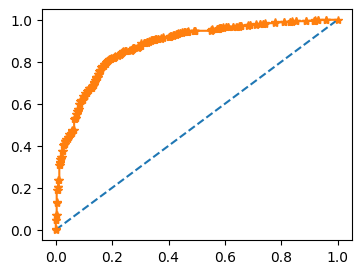

In [ ]:
auc_trainLDA=roc_auc_score(y_train,y_trainprobsLDA)
print(auc_trainLDA)
fpr,tpr,thresholds=roc_curve(y_train,y_trainprobsLDA)
plt.figure(figsize=(4,3))
plt.plot([0,1],[0,1],linestyle="--")
plt.plot(fpr,tpr,marker="*")
plt.show()

0.9152702916037077


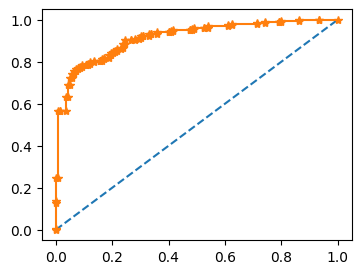

In [ ]:
auc_testLDA=roc_auc_score(y_test,y_testprobsLDA)
print(auc_testLDA)
fpr,tpr,thresholds=roc_curve(y_test,y_testprobsLDA)
plt.figure(figsize=(4,3))
plt.plot([0,1],[0,1],linestyle="--")
plt.plot(fpr,tpr,marker="*")
plt.show()

* For Training set, there is no much change in the performance matrix after using hyperparameters, all the metrics remains same.
* For test set, accuracy increased by 1%, besides that there are no much difference in other parameters.
* AUC scores remain same for both train and test sets

# Grid Search - KNN
Best hyper parameters are found for optimizing the model.

In [ ]:
param_grid={"n_neighbors": list(range(1,9)),
            "weights":("uniform","distance"),
            "metric": ("minkowski","euclidean","manhattan")}
gs2=GridSearchCV(knn,param_grid,cv=10)
gs2.fit(X_trainscaled,y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'metric': ('minkowski', 'euclidean', 'manhattan'),
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8],
                         'weights': ('uniform', 'distance')})

In [ ]:
gs2.cv_results_["params"]

[{'metric': 'minkowski', 'n_neighbors': 1, 'weights': 'uniform'},
 {'metric': 'minkowski', 'n_neighbors': 1, 'weights': 'distance'},
 {'metric': 'minkowski', 'n_neighbors': 2, 'weights': 'uniform'},
 {'metric': 'minkowski', 'n_neighbors': 2, 'weights': 'distance'},
 {'metric': 'minkowski', 'n_neighbors': 3, 'weights': 'uniform'},
 {'metric': 'minkowski', 'n_neighbors': 3, 'weights': 'distance'},
 {'metric': 'minkowski', 'n_neighbors': 4, 'weights': 'uniform'},
 {'metric': 'minkowski', 'n_neighbors': 4, 'weights': 'distance'},
 {'metric': 'minkowski', 'n_neighbors': 5, 'weights': 'uniform'},
 {'metric': 'minkowski', 'n_neighbors': 5, 'weights': 'distance'},
 {'metric': 'minkowski', 'n_neighbors': 6, 'weights': 'uniform'},
 {'metric': 'minkowski', 'n_neighbors': 6, 'weights': 'distance'},
 {'metric': 'minkowski', 'n_neighbors': 7, 'weights': 'uniform'},
 {'metric': 'minkowski', 'n_neighbors': 7, 'weights': 'distance'},
 {'metric': 'minkowski', 'n_neighbors': 8, 'weights': 'uniform'},
 {'

In [ ]:
gs2.best_params_

{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'uniform'}

In [ ]:
KNN=KNeighborsClassifier(metric="manhattan",n_neighbors=5,weights="uniform")
knn=KNeighborsClassifier()
model_KNN=KNN.fit(X_trainscaled,y_train)
ytrain_predictKNN=model_KNN.predict(X_trainscaled)
ytest_predictKNN=model_KNN.predict(X_testscaled)
print(metrics.confusion_matrix(y_train,ytrain_predictKNN))
print(metrics.classification_report(y_train,ytrain_predictKNN))

[[237  86]
 [ 59 685]]
              precision    recall  f1-score   support

           0       0.80      0.73      0.77       323
           1       0.89      0.92      0.90       744

    accuracy                           0.86      1067
   macro avg       0.84      0.83      0.84      1067
weighted avg       0.86      0.86      0.86      1067



In [ ]:
print(metrics.confusion_matrix(y_test,ytest_predictKNN))
print(metrics.classification_report(y_test,ytest_predictKNN))

[[101  38]
 [ 33 286]]
              precision    recall  f1-score   support

           0       0.75      0.73      0.74       139
           1       0.88      0.90      0.89       319

    accuracy                           0.84       458
   macro avg       0.82      0.81      0.81       458
weighted avg       0.84      0.84      0.84       458



In [ ]:
y_trainprobsKNN=model_KNN.predict_proba(X_train)
y_testprobsKNN=model_KNN.predict_proba(X_test)

In [ ]:
y_trainprobsKNN=y_trainprobsKNN[:,1]

In [ ]:
y_testprobsKNN=y_testprobsKNN[:,1]

0.5380359699057891


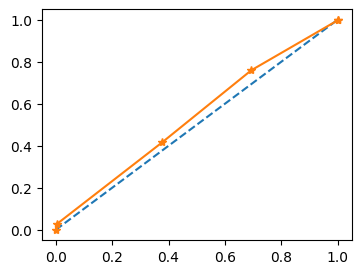

In [ ]:
auc_trainKNN=roc_auc_score(y_train,y_trainprobsKNN)
print(auc_trainKNN)
fpr,tpr,thresholds=roc_curve(y_train,y_trainprobsKNN)
plt.figure(figsize=(4,3))
plt.plot([0,1],[0,1],linestyle="--")
plt.plot(fpr,tpr,marker="*")
plt.show()

0.5942581358111003


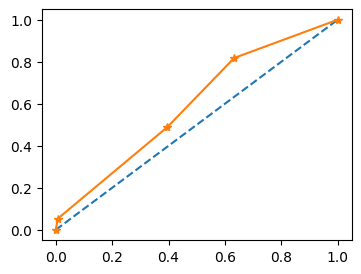

In [ ]:
auc_testKNN=roc_auc_score(y_test,y_testprobsKNN)
print(auc_testKNN)
fpr,tpr,thresholds=roc_curve(y_test,y_testprobsKNN)
plt.figure(figsize=(4,3))
plt.plot([0,1],[0,1],linestyle="--")
plt.plot(fpr,tpr,marker="*")
plt.show()

* For training set, True positves have increased, True negatives decreased.
* For class 0 precision and f1 score increased, whereas for class 1, recall increased.
* For test set, True positives and true negatives are increased.
* Precision,recall and f1 scores have also increased.
* Accuracy has also increased by 1%.
* AUC scores have decreased to 53% and 59%


# Grid Search - Gaussian NB
For improving the optimization of the Gaussian Naïve Bayes model, GridSearchCV
is used to find the best hyper parameters

In [ ]:
param_grid={"priors": [None],
            "var_smoothing": (0.000001,0.00001,0.000000001)}
gs3=GridSearchCV(NB,param_grid,cv=10)
gs3.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=GaussianNB(),
             param_grid={'priors': [None],
                         'var_smoothing': (1e-06, 1e-05, 1e-09)})

In [ ]:
gs3.cv_results_["params"]

[{'priors': None, 'var_smoothing': 1e-06},
 {'priors': None, 'var_smoothing': 1e-05},
 {'priors': None, 'var_smoothing': 1e-09}]

In [ ]:
gs3.best_params_

{'priors': None, 'var_smoothing': 1e-06}

In [ ]:
GNB=GaussianNB(priors=None,var_smoothing=0.000001)
model_GNB=GNB.fit(X_train,y_train)
ytrain_predictGNB=model_GNB.predict(X_train)
ytest_predictGNB=model_GNB.predict(X_test)
print(metrics.confusion_matrix(y_train,ytrain_predictGNB))
print(metrics.classification_report(y_train,ytrain_predictGNB))

[[223 100]
 [ 90 654]]
              precision    recall  f1-score   support

           0       0.71      0.69      0.70       323
           1       0.87      0.88      0.87       744

    accuracy                           0.82      1067
   macro avg       0.79      0.78      0.79      1067
weighted avg       0.82      0.82      0.82      1067



In [ ]:
print(metrics.confusion_matrix(y_test,ytest_predictGNB))
print(metrics.classification_report(y_test,ytest_predictGNB))

[[101  38]
 [ 32 287]]
              precision    recall  f1-score   support

           0       0.76      0.73      0.74       139
           1       0.88      0.90      0.89       319

    accuracy                           0.85       458
   macro avg       0.82      0.81      0.82       458
weighted avg       0.85      0.85      0.85       458



In [ ]:
y_trainprobsGNB=model_GNB.predict_proba(X_train)
y_testprobsGNB=model_GNB.predict_proba(X_test)

In [ ]:
y_trainprobsGNB=y_trainprobsGNB[:,1]

In [ ]:
y_testprobsGNB=y_testprobsGNB[:,1]

0.8743695695595727


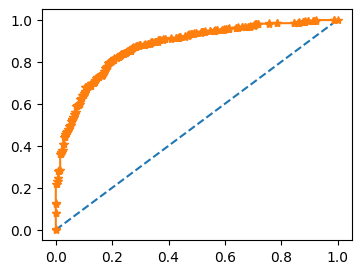

In [ ]:
auc_trainGNB=roc_auc_score(y_train,y_trainprobsGNB)
print(auc_trainGNB)
fpr,tpr,thresholds=roc_curve(y_train,y_trainprobsGNB)
plt.figure(figsize=(4,3))
plt.plot([0,1],[0,1],linestyle="--")
plt.plot(fpr,tpr,marker="*")
plt.show()

0.909993008727814


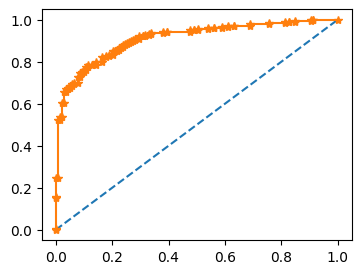

In [ ]:
auc_testGNB=roc_auc_score(y_test,y_testprobsGNB)
print(auc_testGNB)
fpr,tpr,thresholds=roc_curve(y_test,y_testprobsGNB)
plt.figure(figsize=(4,3))
plt.plot([0,1],[0,1],linestyle="--")
plt.plot(fpr,tpr,marker="*")
plt.show()

* For training and test set, there isn’t any difference in any of the performance metrics.
* AUC scores are also same as before for both the sets

# Bagging Classifier
Random Forest Classifier is used as base estimator model for tuning Bagging
classifier

In [ ]:
param_grid={"n_estimators": [25,50,100,150],
            "max_features": ["sqrt","log2",None],
            "max_leaf_nodes" : [3,6,9]}
gs4=GridSearchCV(RandomForestClassifier(),param_grid=param_grid)
gs4.fit(X_train,y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_features': ['sqrt', 'log2', None],
                         'max_leaf_nodes': [3, 6, 9],
                         'n_estimators': [25, 50, 100, 150]})

In [ ]:
gs4.cv_results_["params"]

[{'max_features': 'sqrt', 'max_leaf_nodes': 3, 'n_estimators': 25},
 {'max_features': 'sqrt', 'max_leaf_nodes': 3, 'n_estimators': 50},
 {'max_features': 'sqrt', 'max_leaf_nodes': 3, 'n_estimators': 100},
 {'max_features': 'sqrt', 'max_leaf_nodes': 3, 'n_estimators': 150},
 {'max_features': 'sqrt', 'max_leaf_nodes': 6, 'n_estimators': 25},
 {'max_features': 'sqrt', 'max_leaf_nodes': 6, 'n_estimators': 50},
 {'max_features': 'sqrt', 'max_leaf_nodes': 6, 'n_estimators': 100},
 {'max_features': 'sqrt', 'max_leaf_nodes': 6, 'n_estimators': 150},
 {'max_features': 'sqrt', 'max_leaf_nodes': 9, 'n_estimators': 25},
 {'max_features': 'sqrt', 'max_leaf_nodes': 9, 'n_estimators': 50},
 {'max_features': 'sqrt', 'max_leaf_nodes': 9, 'n_estimators': 100},
 {'max_features': 'sqrt', 'max_leaf_nodes': 9, 'n_estimators': 150},
 {'max_features': 'log2', 'max_leaf_nodes': 3, 'n_estimators': 25},
 {'max_features': 'log2', 'max_leaf_nodes': 3, 'n_estimators': 50},
 {'max_features': 'log2', 'max_leaf_nodes'

In [ ]:
gs4.best_params_

{'max_features': 'log2', 'max_leaf_nodes': 9, 'n_estimators': 50}

In [ ]:
BC1=BaggingClassifier(estimator=RandomForestClassifier(max_features="log2",max_leaf_nodes=9,n_estimators=50),random_state=1)
modelBC1=BC1.fit(X_train,y_train)
ytrain_predictBC1=modelBC1.predict(X_train)
ytest_predictBC1=modelBC1.predict(X_test)
print(metrics.confusion_matrix(y_train,ytrain_predictBC1))
print(metrics.classification_report(y_train,ytrain_predictBC1))

[[199 124]
 [ 47 697]]
              precision    recall  f1-score   support

           0       0.81      0.62      0.70       323
           1       0.85      0.94      0.89       744

    accuracy                           0.84      1067
   macro avg       0.83      0.78      0.80      1067
weighted avg       0.84      0.84      0.83      1067



In [ ]:
print(metrics.confusion_matrix(y_test,ytest_predictBC1))
print(metrics.classification_report(y_test,ytest_predictBC1))

[[ 80  59]
 [ 18 301]]
              precision    recall  f1-score   support

           0       0.82      0.58      0.68       139
           1       0.84      0.94      0.89       319

    accuracy                           0.83       458
   macro avg       0.83      0.76      0.78       458
weighted avg       0.83      0.83      0.82       458



In [ ]:
y_trainprobsBC1=modelBC1.predict_proba(X_train)
y_testprobsBC1=modelBC1.predict_proba(X_test)

In [ ]:
y_trainprobsBC1=y_trainprobsBC1[:,1]

In [ ]:
y_testprobsBC1=y_testprobsBC1[:,1]

0.8995160458071174


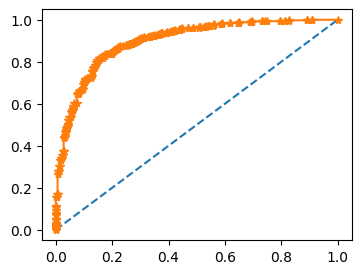

In [ ]:
auc_trainBC1=roc_auc_score(y_train,y_trainprobsBC1)
print(auc_trainBC1)
fpr,tpr,thresholds=roc_curve(y_train,y_trainprobsBC1)
plt.figure(figsize=(4,3))
plt.plot([0,1],[0,1],linestyle="--")
plt.plot(fpr,tpr,marker="*")
plt.show()

0.9105568210008795


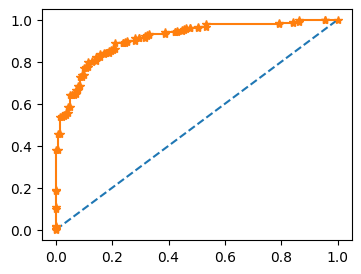

In [ ]:
auc_testBC1=roc_auc_score(y_test,y_testprobsBC1)
print(auc_testBC1)
fpr,tpr,thresholds=roc_curve(y_test,y_testprobsBC1)
plt.figure(figsize=(4,3))
plt.plot([0,1],[0,1],linestyle="--")
plt.plot(fpr,tpr,marker="*")
plt.show()

In [ ]:
RF=RandomForestClassifier(max_features="log2",max_leaf_nodes=9,n_estimators=50,random_state=1)
model_rf=RF.fit(X_train,y_train)

In [ ]:
print(pd.DataFrame(RF.feature_importances_,columns=["Imp"],index=X_train.columns))

                              Imp
age                      0.056439
economic.cond.national   0.053759
economic.cond.household  0.013539
Blair                    0.192258
Hague                    0.363930
Europe                   0.233463
political.knowledge      0.084211
gender_male              0.002400


* Accuracy for both the models is almost same.
* For class 0, recall and f1 score are higher in training set than in test set.
* For class 1, precision is more for test set than training set.

#Boosting Classifier
AdaBoosting classifier is tuned using n_estimators value set as 100 and
random_state as 1.

In [ ]:

AB=AdaBoostClassifier(n_estimators=100,random_state=1)
modelAB=AB.fit(X_train,y_train)

In [ ]:
ytrain_predictAB=modelAB.predict(X_train)
ytest_predictAB=modelAB.predict(X_test)
print(metrics.confusion_matrix(y_train,ytrain_predictAB))
print(metrics.classification_report(y_train,ytrain_predictAB))

[[227  96]
 [ 70 674]]
              precision    recall  f1-score   support

           0       0.76      0.70      0.73       323
           1       0.88      0.91      0.89       744

    accuracy                           0.84      1067
   macro avg       0.82      0.80      0.81      1067
weighted avg       0.84      0.84      0.84      1067



In [ ]:
print(metrics.confusion_matrix(y_test,ytest_predictAB))
print(metrics.classification_report(y_test,ytest_predictAB))

[[ 94  45]
 [ 30 289]]
              precision    recall  f1-score   support

           0       0.76      0.68      0.71       139
           1       0.87      0.91      0.89       319

    accuracy                           0.84       458
   macro avg       0.81      0.79      0.80       458
weighted avg       0.83      0.84      0.83       458



In [ ]:
y_trainprobsAB=modelAB.predict_proba(X_train)
y_testprobsAB=modelAB.predict_proba(X_test)

In [ ]:
y_trainprobsAB=y_trainprobsAB[:,1]

In [ ]:
y_testprobsAB=y_testprobsAB[:,1]

0.9023623456173641


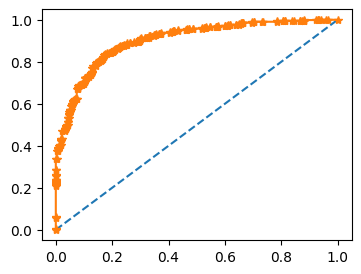

In [ ]:
auc_trainAB=roc_auc_score(y_train,y_trainprobsAB)
print(auc_trainAB)
fpr,tpr,thresholds=roc_curve(y_train,y_trainprobsAB)
plt.figure(figsize=(4,3))
plt.plot([0,1],[0,1],linestyle="--")
plt.plot(fpr,tpr,marker="*")
plt.show()

0.9058207979071289


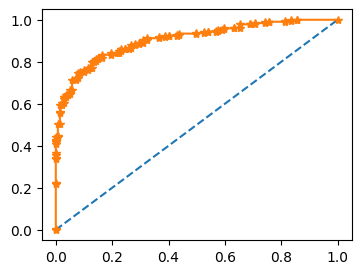

In [ ]:
auc_testAB=roc_auc_score(y_test,y_testprobsAB)
print(auc_testAB)
fpr,tpr,thresholds=roc_curve(y_test,y_testprobsAB)
plt.figure(figsize=(4,3))
plt.plot([0,1],[0,1],linestyle="--")
plt.plot(fpr,tpr,marker="*")
plt.show()

* Both the train and test have same accuracy.
* For training set, for class 0: recall and f1 score values are high than test set.


# Gradient Boosting
Gradient boosting is modelled using n_estimators and random_state as parameters.


In [ ]:

GB=GradientBoostingClassifier(n_estimators=100,random_state=1)
modelGB=GB.fit(X_train,y_train)

In [ ]:
ytrain_predictGB=modelGB.predict(X_train)
ytest_predictGB=modelGB.predict(X_test)
print(metrics.confusion_matrix(y_train,ytrain_predictGB))
print(metrics.classification_report(y_train,ytrain_predictGB))

[[246  77]
 [ 43 701]]
              precision    recall  f1-score   support

           0       0.85      0.76      0.80       323
           1       0.90      0.94      0.92       744

    accuracy                           0.89      1067
   macro avg       0.88      0.85      0.86      1067
weighted avg       0.89      0.89      0.89      1067



In [ ]:
print(metrics.confusion_matrix(y_test,ytest_predictGB))
print(metrics.classification_report(y_test,ytest_predictGB))

[[ 92  47]
 [ 27 292]]
              precision    recall  f1-score   support

           0       0.77      0.66      0.71       139
           1       0.86      0.92      0.89       319

    accuracy                           0.84       458
   macro avg       0.82      0.79      0.80       458
weighted avg       0.83      0.84      0.83       458



In [ ]:
y_trainprobsGB=modelGB.predict_proba(X_train)
y_testprobsGB=modelGB.predict_proba(X_test)

In [ ]:
y_trainprobsGB=y_trainprobsGB[:,1]

In [ ]:
y_testprobsGB=y_testprobsGB[:,1]

0.947807433669563


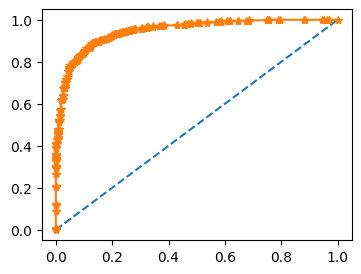

In [ ]:
auc_trainGB=roc_auc_score(y_train,y_trainprobsGB)
print(auc_trainGB)
fpr,tpr,thresholds=roc_curve(y_train,y_trainprobsGB)
plt.figure(figsize=(4,3))
plt.plot([0,1],[0,1],linestyle="--")
plt.plot(fpr,tpr,marker="*")
plt.show()

0.9083015719086173


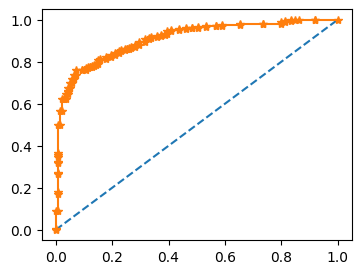

In [ ]:
auc_testGB=roc_auc_score(y_test,y_testprobsGB)
print(auc_testGB)
fpr,tpr,thresholds=roc_curve(y_test,y_testprobsGB)
plt.figure(figsize=(4,3))
plt.plot([0,1],[0,1],linestyle="--")
plt.plot(fpr,tpr,marker="*")
plt.show()

Accuracy, precision, recall is having high values in training set than in testing set

# Best Model Selection:
* From all the performance metrics of all the models, it is clear that Gradient boosting algorithm is performing very well in predicting both the classes of interest.
* It is able to predict high number of True Positives and True Negatives than all the other models.
* The area under ROC curve is more for Gradient Boosting which is 94.7%for training and 90.8% for test set.
* Recall and Precision also have higher values.
* Therefore, it is best model for further predictions.

#Recommendations:
* From Feature importance’s, it is clear that considering the assessment of
party leaders, the party’s stand on European Integration are affecting in the
results of voting.
* Voters who have given high assessment on national economic condition have
opted to vote for Labour party, we can get to know more about it on why they
considered it.
* More number of voters have given Blair high rating of and Hague less rating,
we can get know more about what factors have affected them to give the type
of assessment on Leaders of the party.
* Voters who have high positive sentiment towards European Integration have
voted for Conservative and who have less sentiment have opted to vote for
Labour party.
* Voters who know about the Party position on European integration opted to
vote for Labour party.
* Gender of the voters, household economic condition of the voters doesn’t
have much impact on who they vote